Start with installing and importing required dependencies.

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import heapq
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

Calculate basic dataset statistics.

In [2]:
wine_dataset = datasets.load_wine()
wine_df = pd.DataFrame(wine_dataset.data, columns = wine_dataset.feature_names)
wine_df['wine_type'] = wine_dataset.target
wine_df.describe().T[['count', 'min', 'max']]

count     min      max
alcohol                       178.0   11.03    14.83
malic_acid                    178.0    0.74     5.80
ash                           178.0    1.36     3.23
alcalinity_of_ash             178.0   10.60    30.00
magnesium                     178.0   70.00   162.00
total_phenols                 178.0    0.98     3.88
flavanoids                    178.0    0.34     5.08
nonflavanoid_phenols          178.0    0.13     0.66
proanthocyanins               178.0    0.41     3.58
color_intensity               178.0    1.28    13.00
hue                           178.0    0.48     1.71
od280/od315_of_diluted_wines  178.0    1.27     4.00
proline                       178.0  278.00  1680.00
wine_type                     178.0    0.00     2.00

Understand the target variable distribution.

In [3]:
pd.DataFrame(wine_df.wine_type.value_counts(normalize = True).round(2))

proportion
wine_type            
1                0.40
0                0.33
2                0.27

Build the correlation plot and the correlation heatmap.

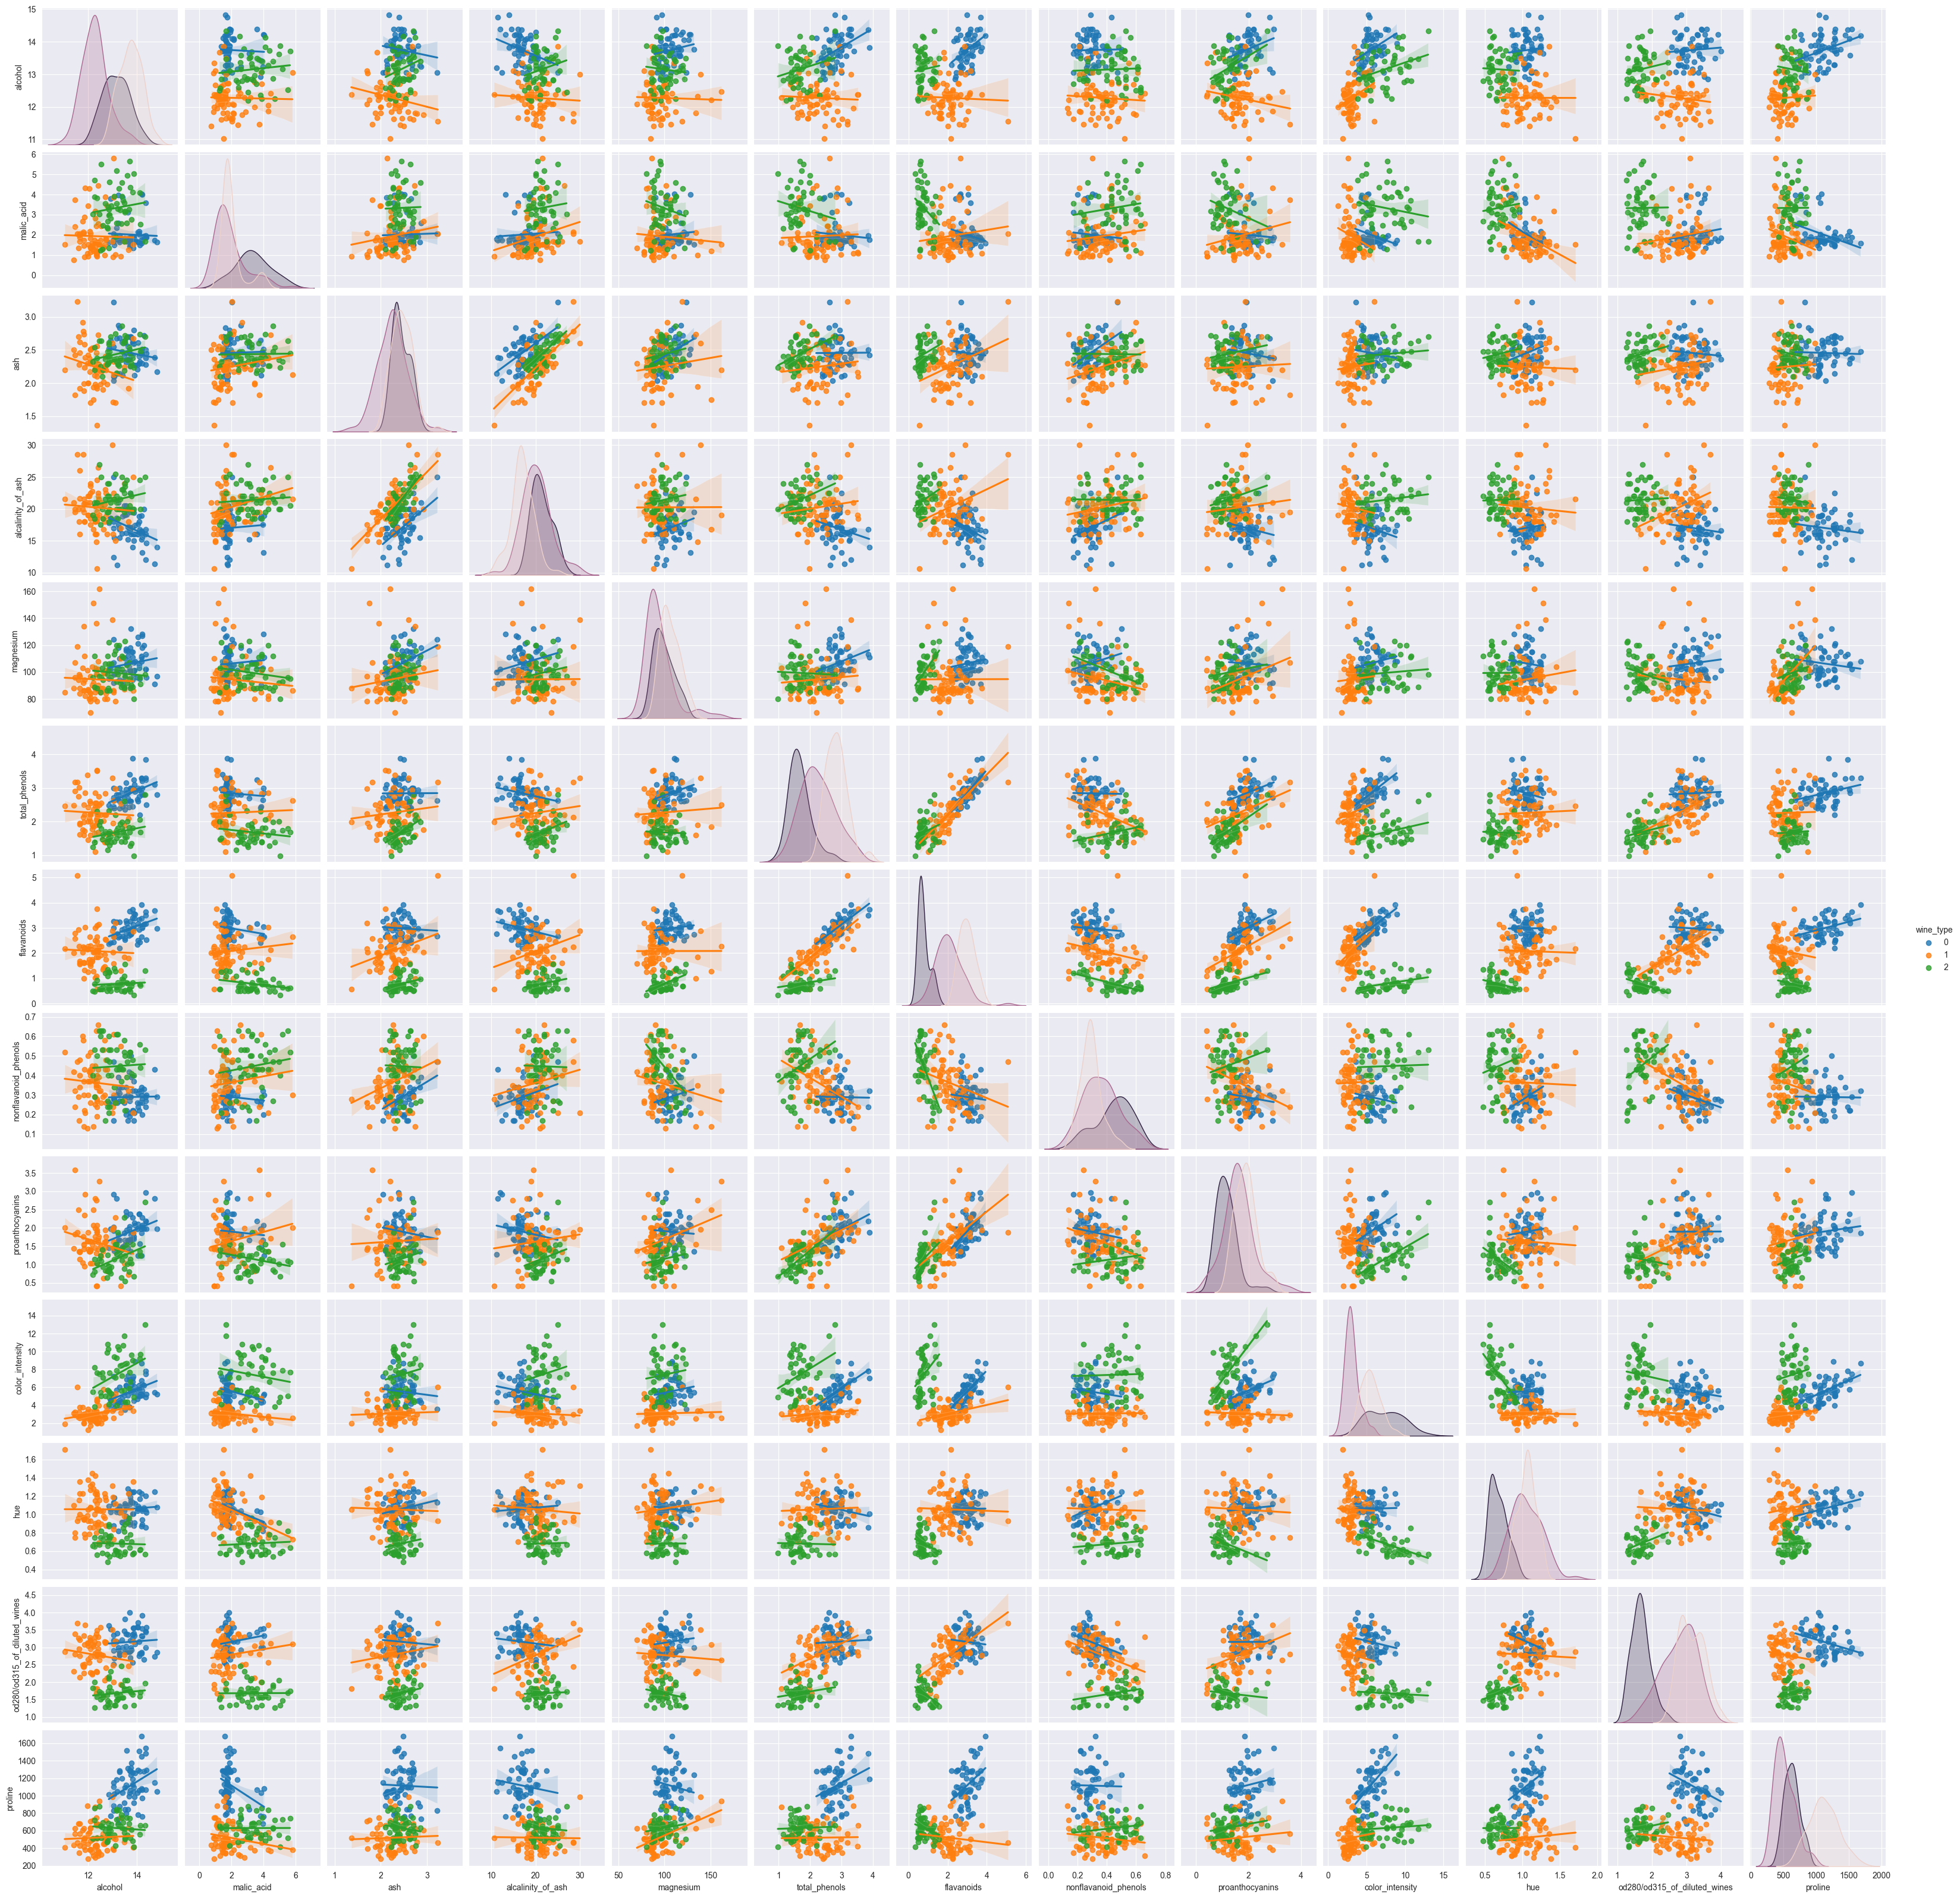

In [4]:
sns.pairplot(wine_df, kind = 'reg', hue = "wine_type")
plt.show()

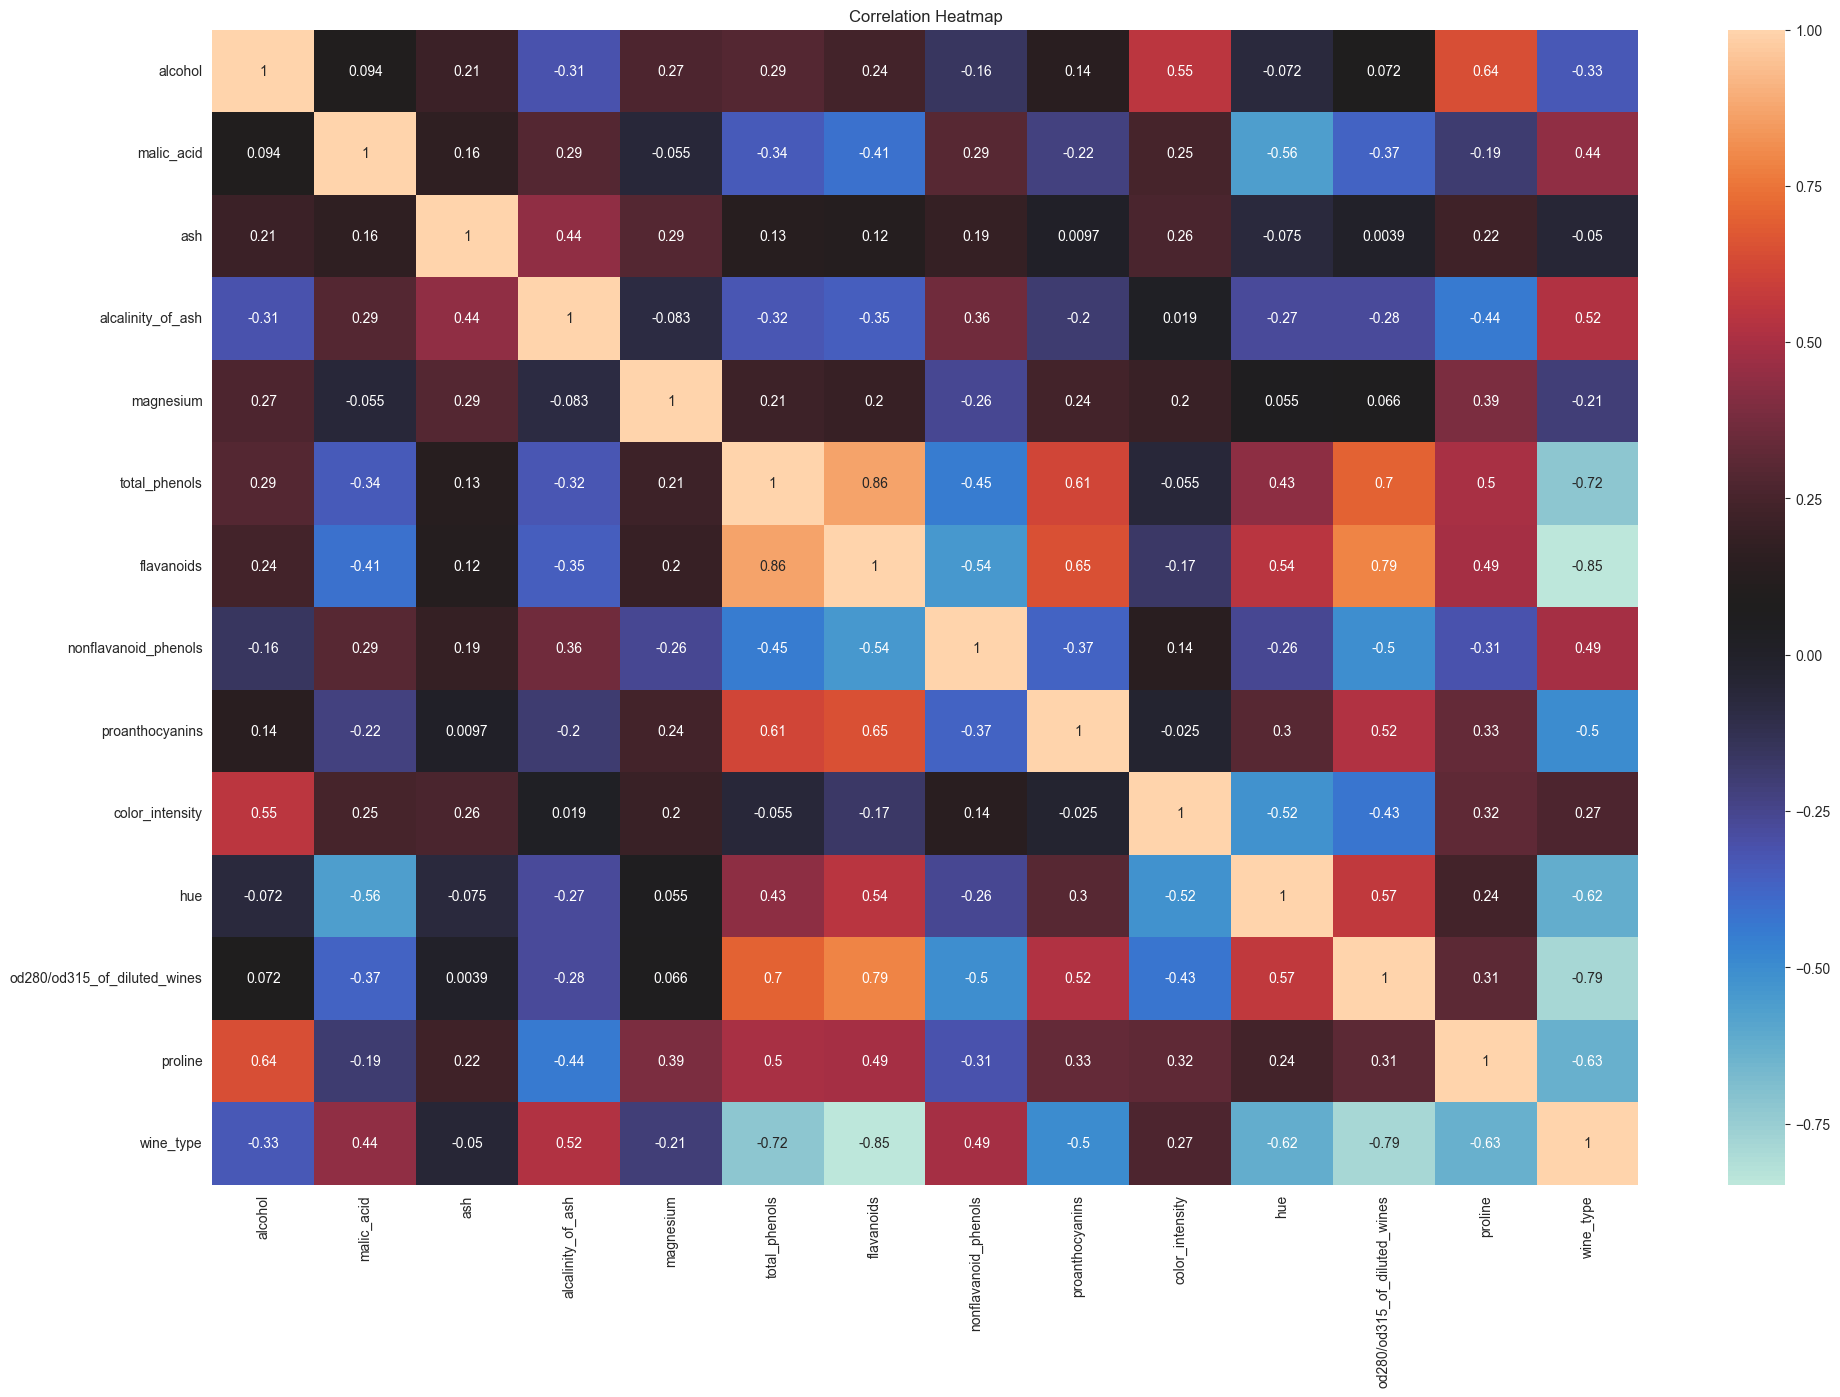

In [5]:
correlations = wine_df.corr()
plt.subplots(1, 1, figsize = (23, 15))
sns.heatmap(correlations, cmap = 'icefire', annot = True)
plt.title('Correlation Heatmap')
plt.show()

Analyze PCA variance.

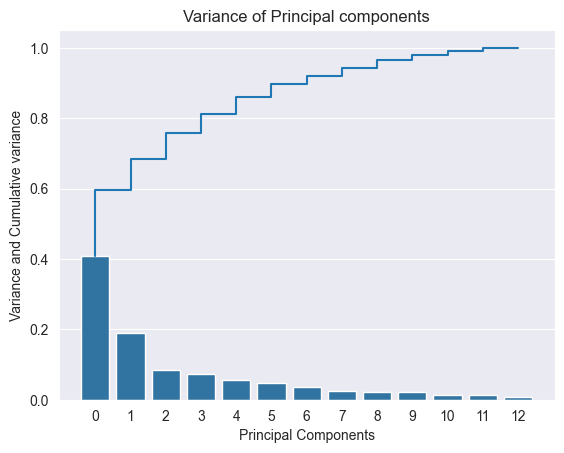

In [6]:
wine_df_X_scaled = MinMaxScaler().fit_transform(wine_df.loc[:, wine_df.columns != 'wine_type'])

pca = PCA()
pca.fit(wine_df_X_scaled)

pc_indices = np.arange(0, wine_df_X_scaled.shape[1])
sns.barplot(x = pc_indices, y = pca.explained_variance_ratio_)
sns.lineplot(x = pc_indices, y = np.cumsum(pca.explained_variance_ratio_), drawstyle = 'steps-pre')
plt.xlabel("Principal Components")
plt.ylabel("Variance and Cumulative variance")
plt.title("Variance of Principal components")
plt.show()

Implement the kNN classifier from scratch. It is not the most optimal but correct and works fine for our data volumes.

In [7]:
class MyKnnClassifier:
    """
    kNN classifier calculates distances between the test feature vector and all the training feature vectors. Then, it selects top k training samples with the smallest distance to the test vector. The mode of the target variable in the k resulting training samples is the predicted class. The distance function and the k value are the configurable parameters.
    """
    def __init__(self, k, distance):
        """
        Creates an instance of the kNN classifier.

        :param int k: number of neighbour vectors to consider
        :param str distance: 'euclidean' or 'manhattan', the type of distance function

        :returns: An instance of the kNN classifier
        :rtype: MyKnnClassifier
        """
        self.k = k
        self.distance = distance
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Trains the classifier.

        :param pandas.DataFrame or numpy.ndarray X: training features
        :param pandas.Series or numpy.ndarray y: training classes

        :returns: An instance of the kNN classifier
        :rtype: MyKnnClassifier
        """
        self.X_train = X if type(X) == np.ndarray else X.values
        self.y_train = y if type(y) == np.ndarray else y.values
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        """
        Predicts classes.
        
        :param pandas.DataFrame or numpy.ndarray X: features to predict a class for
        
        :returns: Predicted class labels
        :rtype: list
        """
        distance_func = self._euclidean_distance if self.distance == 'euclidean' else self._manhattan_distance
        y_pred = []
        for x_test in X if type(X) == np.ndarray else X.values:
            y_pred.append(
                np.argmax(np.bincount([self.y_train[i] for i in self._find_k_nearest(self.X_train, x_test, self.k, distance_func)]))
            )
        return y_pred

    #not very optimal, but works fine for our size of the data
    def _find_k_nearest(self, X, x, k, distance_func):
        indexed_X = [(i, x) for i, x in enumerate(X)]
        return [indexed_x[0]
                for indexed_x
                in heapq.nsmallest(k, indexed_X, lambda indexed_x: distance_func(indexed_x[1], x))]

    def _euclidean_distance(self, x1, x2):
        return np.linalg.norm(x1 - x2)

    def _manhattan_distance(delf, x1, x2):
        return np.abs(x1 - x2).sum()

    def __repr__(self):
        return f'MyKnnClassifier(distance={self.distance}, k={self.k})'

Define ML pipeline and Grid Search parameters.

In [38]:
pipeline = Pipeline([
    ('scale', MinMaxScaler()),
    ('transform', None),
    ('select', None),
    ('classify', None)
])

classifiers = [
    MyKnnClassifier(k = 1, distance = 'euclidean'),
    MyKnnClassifier(k = 3, distance = 'euclidean'),
    MyKnnClassifier(k = 5, distance = 'euclidean'),
    MyKnnClassifier(k = 1, distance = 'manhattan'),
    MyKnnClassifier(k = 3, distance = 'manhattan'),
    MyKnnClassifier(k = 5, distance = 'manhattan'),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis(),
    GaussianNB(),
    DecisionTreeClassifier(max_depth = 3, random_state = 456),
    DecisionTreeClassifier(max_depth = 5, random_state = 456),
    DecisionTreeClassifier(max_depth = 7, random_state = 456),
    RandomForestClassifier(n_estimators = 2, max_depth = 3, random_state = 456),
    RandomForestClassifier(n_estimators = 5, max_depth = 3, random_state = 456),
    RandomForestClassifier(n_estimators = 10, max_depth = 3, random_state = 456),
    RandomForestClassifier(n_estimators = 2, max_depth = 5, random_state = 456),
    RandomForestClassifier(n_estimators = 5, max_depth = 5, random_state = 456),
    RandomForestClassifier(n_estimators = 10, max_depth = 5, random_state = 456),
    RandomForestClassifier(n_estimators = 2, max_depth = 7, random_state = 456),
    RandomForestClassifier(n_estimators = 5, max_depth = 7, random_state = 456),
    RandomForestClassifier(n_estimators = 10, max_depth = 7, random_state = 456)
]

param_grid = [
    {
        'transform': [PCA(n_components = 1)],
        'select': [SelectKBest()],
        'select__k' : [1],
        'classify': classifiers
    },
    {
        'transform': [PCA(n_components = 3)],
        'select': [SelectKBest()],
        'select__k' : [1, 3],
        'classify': classifiers
    },
    {
        'transform': [PCA(n_components = 5)],
        'select': [SelectKBest()],
        'select__k' : [1, 3, 5],
        'classify': classifiers
    },
    {
        'transform': [PCA(n_components = 10)],
        'select': [SelectKBest()],
        'select__k' : [1, 3, 5, 10],
        'classify': classifiers
    },
    {
        'transform': [PCA()],
        'select': [SelectKBest()],
        'select__k' : [1, 3, 5, 10, 'all'],
        'classify': classifiers
    },
    {
        'transform': [FunctionTransformer()],
        'select': [SelectKBest()],
        'select__k' : [1, 3, 5, 10, 'all'],
        'classify': classifiers
    },
    {
        'transform': [PCA(n_components = 1)],
        # select first `number_of_features` features
        'select': [FunctionTransformer(lambda X, number_of_features: X[:,:number_of_features])],
        'select__kw_args' : [
            {'number_of_features': 1}
        ],
        'classify': classifiers
    },
    {
        'transform': [PCA(n_components = 3)],
        # select first `number_of_features` features
        'select': [FunctionTransformer(lambda X, number_of_features: X[:,:number_of_features])],
        'select__kw_args' : [
            {'number_of_features': 1},
            {'number_of_features': 3}
        ],
        'classify': classifiers
    },
    {
        'transform': [PCA(n_components = 5)],
        # select first `number_of_features` features
        'select': [FunctionTransformer(lambda X, number_of_features: X[:,:number_of_features])],
        'select__kw_args' : [
            {'number_of_features': 1},
            {'number_of_features': 3},
            {'number_of_features': 5}
        ],
        'classify': classifiers
    },
    {
        'transform': [PCA(n_components = 10)],
        # select first `number_of_features` features
        'select': [FunctionTransformer(lambda X, number_of_features: X[:,:number_of_features])],
        'select__kw_args' : [
            {'number_of_features': 1},
            {'number_of_features': 3},
            {'number_of_features': 5},
            {'number_of_features': 10}
        ],
        'classify': classifiers
    },
    {
        'transform': [PCA()],
        # select first `number_of_features` features
        'select': [FunctionTransformer(lambda X, number_of_features: X[:,:number_of_features])],
        'select__kw_args' : [
            {'number_of_features': 1},
            {'number_of_features': 3},
            {'number_of_features': 5},
            {'number_of_features': 10},
            {'number_of_features': 13},
        ],
        'classify': classifiers
    },
    {
        # skip transform
        'transform': [FunctionTransformer()],
        # select features manually based on the correlation plots
        'select': [
            FunctionTransformer(
                lambda X, columns: X[:, [columns.index('flavanoids'), columns.index('total_phenols'), columns.index('hue'), columns.index('od280/od315_of_diluted_wines'), columns.index('proline')]],
                kw_args = {'columns': wine_df.loc[:, wine_df.columns != 'wine_type'].columns.tolist()}
            )
        ],
        'classify': classifiers
    }
]

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 123),
    scoring = 'accuracy',
    refit = False,
    verbose = 1
)

Run the validation.

In [39]:
X = wine_df.loc[:, wine_df.columns != 'wine_type']
y = wine_df['wine_type']
grid_search.fit(X, y)

Fitting 3 folds for each of 756 candidates, totalling 2268 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('transform', None), ('select', None),
                                       ('classify', None)]),
             param_grid=[{'classify': [MyKnnClassifier(distance=euclidean, k=1),
                                       MyKnnClassifier(distance=euclidean, k=3),
                                       MyKnnClassifier(distance=euclidean, k=5),
                                       MyKnnClassifier(distance=...
                          'select': [FunctionTransformer(func=<function <lambda> at 0x134e82160>,
                                                         kw_args={'columns': ['alcohol',
                                                                              'malic_acid',
                                                                              'ash',
                                                                              'alcalinity_of_ash',
                                                                              'magnesium',
                                                                              'total_phenols',
                                                                              'flavanoids',
                                                                              'nonflavanoid_phenols',
                                                                              'proanthocyanins',
                                                                              'color_intensity',
                                                                              'hue',
                                                                              'od280/od315_of_diluted_wines',
                                                                              'proline']})],
                          'transform': [FunctionTransformer()]}],
             refit=False, scoring='accuracy', verbose=1)

Show the best pipeline.

In [40]:
print(grid_search.best_params_)

{'classify': MyKnnClassifier(distance=euclidean, k=3), 'select': SelectKBest(), 'select__k': 5, 'transform': PCA()}


Convert the Grid Search Cross Validation results to the human readable format and display them.

In [41]:
# create Pandas Dataframe for processing the CV results
cv_results_df = pd.DataFrame(grid_search.cv_results_, dtype='string')

# beautify the transform step
# replace "FunctionTransformer()" with "No Transform"
cv_results_df['param_transform'] = cv_results_df['param_transform'].replace('FunctionTransformer()', 'No Transform')
# make PCA() display actual value of `n_components` argument
cv_results_df['param_transform'] = cv_results_df['param_transform'].replace('PCA()', 'PCA(n_components=None)')

# beautify the select step
# make SelectKBest() display actual value of `k` argument
cv_results_df.loc[cv_results_df['param_select__k'] != '<NA>', 'param_select'] = (
    cv_results_df['param_select__k'].apply(lambda k: f'SelectKBest(k={k})')
)
# make FunctionTransformer() for selecting first `number_of_features` features display actual number of selected features
cv_results_df.loc[cv_results_df['param_select__kw_args'] != '<NA>', 'param_select'] = (
    cv_results_df['param_select__kw_args'].apply(
        lambda number_of_features: f'First {"".join([c for c in number_of_features if c.isdigit()])} features' if number_of_features is not pd.NA else None
    )
)
# make FunctionTransformer() for manual feature selection display "Manually selected features"
cv_results_df['param_select'] = cv_results_df['param_select'].replace(r'^FunctionTransformer[\s\S]*$', 'Manually selected features', regex=True)

# leave only interesting columns
cv_results_df = cv_results_df[['param_transform', 'param_select', 'param_classify', 'rank_test_score', 'mean_test_score']]
# convert `rank_test_score` from str to int
cv_results_df['rank_test_score'] = cv_results_df['rank_test_score'].astype(int)

# sort by rank
cv_results_df = cv_results_df.sort_values('rank_test_score')

# display the full resulting DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
cv_results_df

param_transform                param_select  \
217  PCA(n_components=None)            SelectKBest(k=5)   
242  PCA(n_components=None)            SelectKBest(k=5)   
148    PCA(n_components=10)            SelectKBest(k=5)   
144    PCA(n_components=10)            SelectKBest(k=5)   
227  PCA(n_components=None)            SelectKBest(k=5)   
237  PCA(n_components=None)            SelectKBest(k=5)   
232  PCA(n_components=None)            SelectKBest(k=5)   
82      PCA(n_components=5)            SelectKBest(k=3)   
669  PCA(n_components=None)           First 13 features   
249  PCA(n_components=None)          SelectKBest(k=all)   
222  PCA(n_components=None)            SelectKBest(k=5)   
243  PCA(n_components=None)           SelectKBest(k=10)   
354            No Transform          SelectKBest(k=all)   
136    PCA(n_components=10)            SelectKBest(k=5)   
216  PCA(n_components=None)            SelectKBest(k=3)   
674  PCA(n_components=None)           First 13 features   
212  PCA(n_components=None)            SelectKBest(k=5)   
231  PCA(n_components=None)            SelectKBest(k=3)   
152    PCA(n_components=10)            SelectKBest(k=5)   
254  PCA(n_components=None)          SelectKBest(k=all)   
131    PCA(n_components=10)            SelectKBest(k=3)   
132    PCA(n_components=10)            SelectKBest(k=5)   
143    PCA(n_components=10)            SelectKBest(k=3)   
663  PCA(n_components=None)           First 10 features   
573    PCA(n_components=10)           First 10 features   
153    PCA(n_components=10)           SelectKBest(k=10)   
247  PCA(n_components=None)            SelectKBest(k=5)   
402            No Transform            SelectKBest(k=5)   
673  PCA(n_components=None)           First 10 features   
672  PCA(n_components=None)            First 5 features   
251  PCA(n_components=None)            SelectKBest(k=3)   
252  PCA(n_components=None)            SelectKBest(k=5)   
509     PCA(n_components=5)            First 5 features   
727  PCA(n_components=None)            First 5 features   
624    PCA(n_components=10)            First 5 features   
248  PCA(n_components=None)           SelectKBest(k=10)   
89      PCA(n_components=5)            SelectKBest(k=5)   
159    PCA(n_components=10)            SelectKBest(k=3)   
542     PCA(n_components=5)            First 5 features   
581    PCA(n_components=10)           First 10 features   
580    PCA(n_components=10)            First 5 features   
88      PCA(n_components=5)            SelectKBest(k=3)   
192    PCA(n_components=10)            SelectKBest(k=5)   
204    PCA(n_components=10)            SelectKBest(k=5)   
233  PCA(n_components=None)           SelectKBest(k=10)   
161    PCA(n_components=10)           SelectKBest(k=10)   
122     PCA(n_components=5)            SelectKBest(k=5)   
327            No Transform            SelectKBest(k=5)   
322            No Transform            SelectKBest(k=5)   
565    PCA(n_components=10)           First 10 features   
282  PCA(n_components=None)            SelectKBest(k=5)   
246  PCA(n_components=None)            SelectKBest(k=3)   
135    PCA(n_components=10)            SelectKBest(k=3)   
156    PCA(n_components=10)            SelectKBest(k=5)   
155    PCA(n_components=10)            SelectKBest(k=3)   
145    PCA(n_components=10)           SelectKBest(k=10)   
653  PCA(n_components=None)           First 10 features   
244  PCA(n_components=None)          SelectKBest(k=all)   
654  PCA(n_components=None)           First 13 features   
147    PCA(n_components=10)            SelectKBest(k=3)   
349            No Transform          SelectKBest(k=all)   
389            No Transform          SelectKBest(k=all)   
221  PCA(n_components=None)            SelectKBest(k=3)   
338            No Transform           SelectKBest(k=10)   
417            No Transform            SelectKBest(k=5)   
234  PCA(n_components=None)          SelectKBest(k=all)   
664  PCA(n_components=None)           First 13 features   


Prepare the data for the averaged rank heatmaps.

In [42]:
def mean_ranks_by_columns_pair(column1, column2):
    """
    The function groups the CV results by 2 columns and  averages the rank in each group followed by pivoting the result
    :param str column1: First column name
    :param str column2: Second column name
    :return: pd.DataFrame instance ready to building a rank heatmap
    :rtype: pd.DataFrame
    """
    return cv_results_df\
        .groupby([column1, column2])['rank_test_score'].mean().round()\
        .reset_index()\
        .pivot(index = column1, columns = column2, values = 'rank_test_score')

transform_select = mean_ranks_by_columns_pair('param_transform', 'param_select')
transform_classify = mean_ranks_by_columns_pair('param_transform', 'param_classify')
select_classify = mean_ranks_by_columns_pair('param_select', 'param_classify')

Plot the average rank heatmap between Transformation and Selection steps.

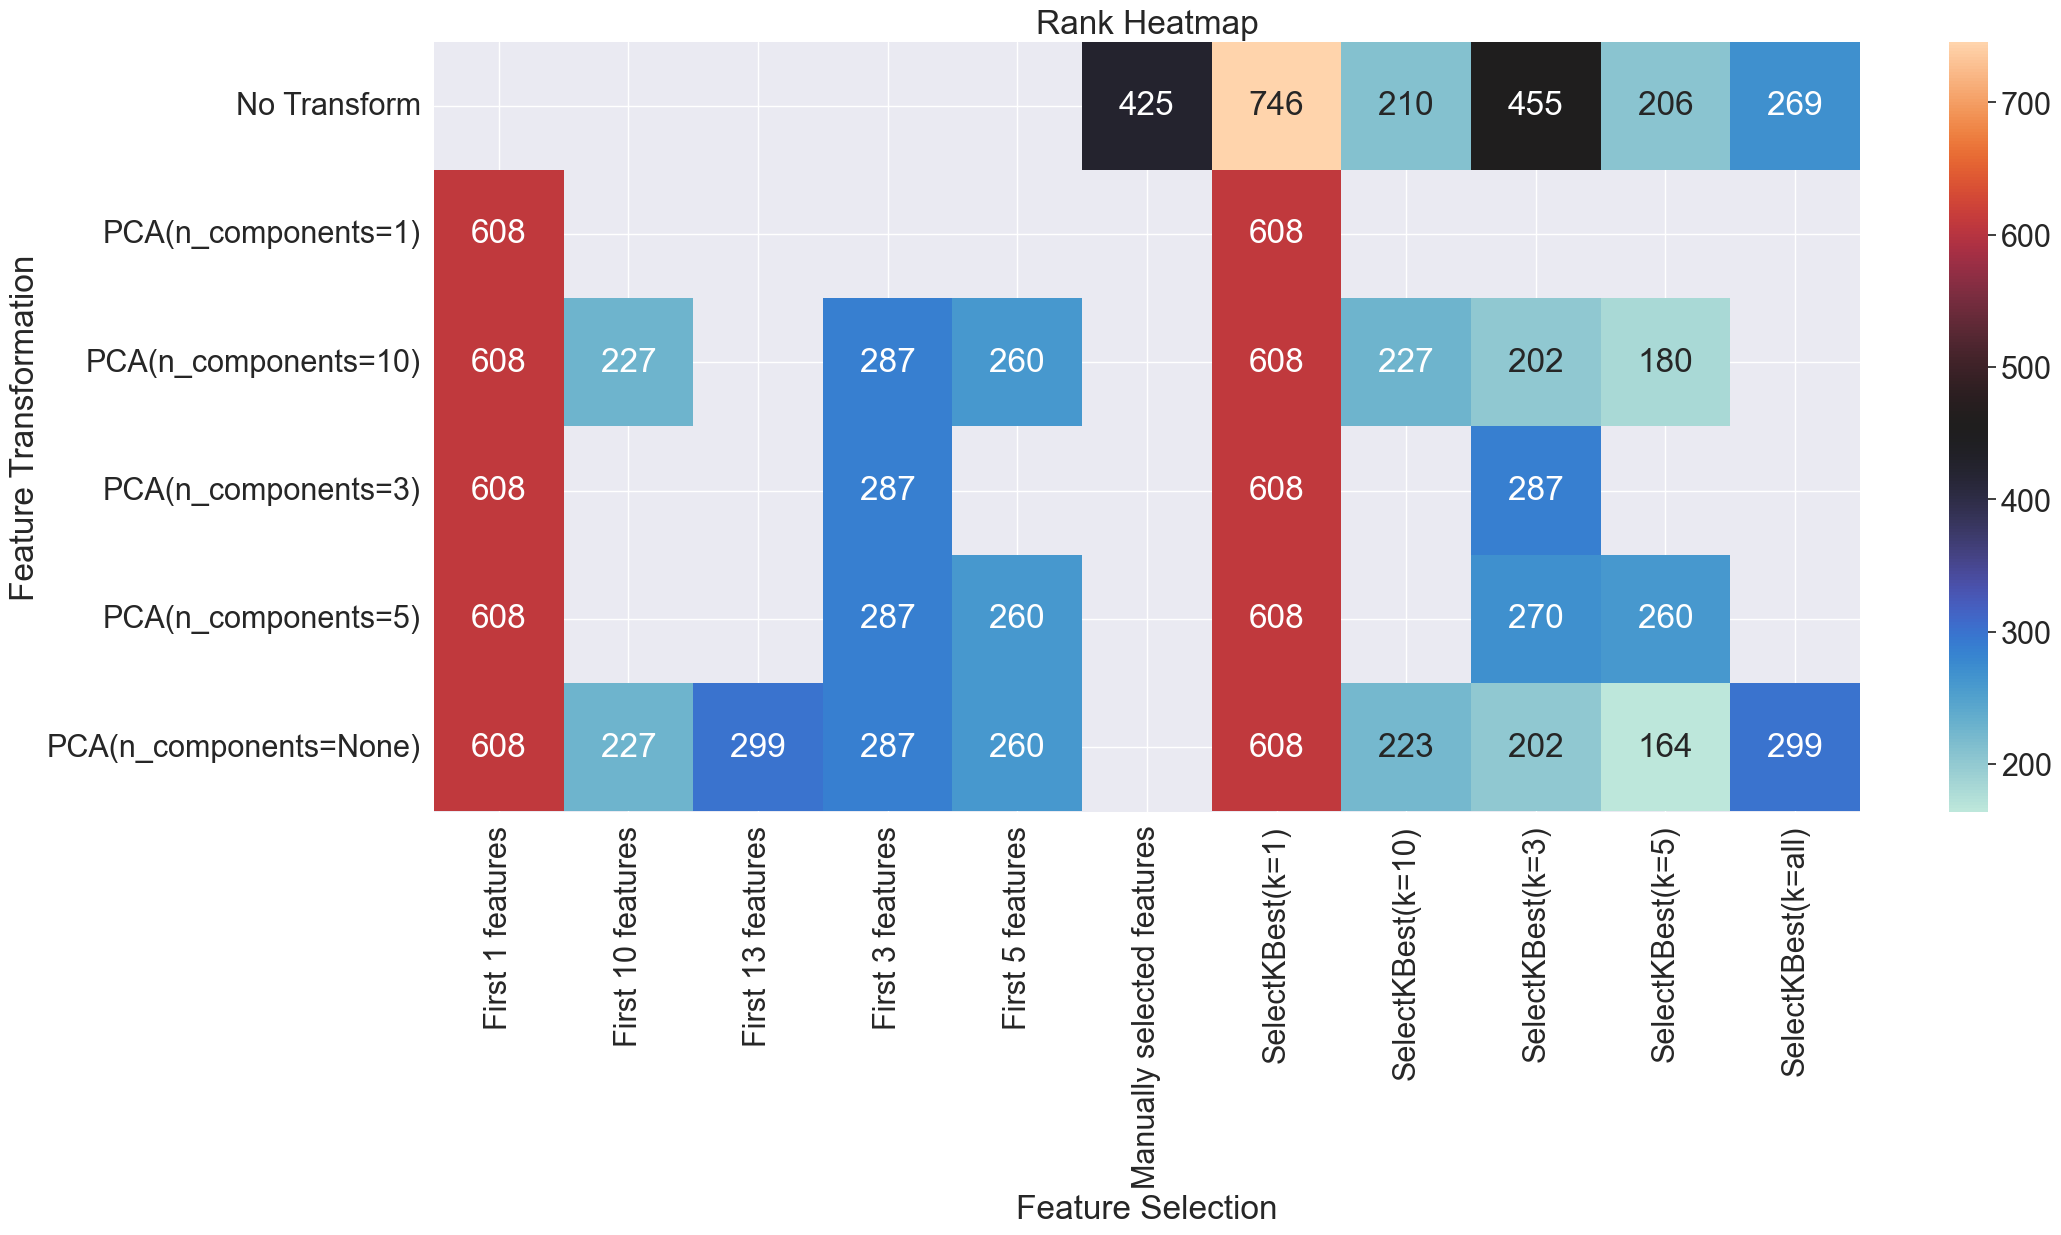

In [43]:
plt.figure(figsize=(23, 10))
sns.set(font_scale = 2)
sns.heatmap(transform_select, cmap='icefire', annot=True, fmt='.0f')
plt.title('Rank Heatmap')
plt.xlabel('Feature Selection')
plt.ylabel('Feature Transformation')
plt.show()

Plot the average rank heatmap between Transformation and Selection steps but only the part required for Experiment 2.

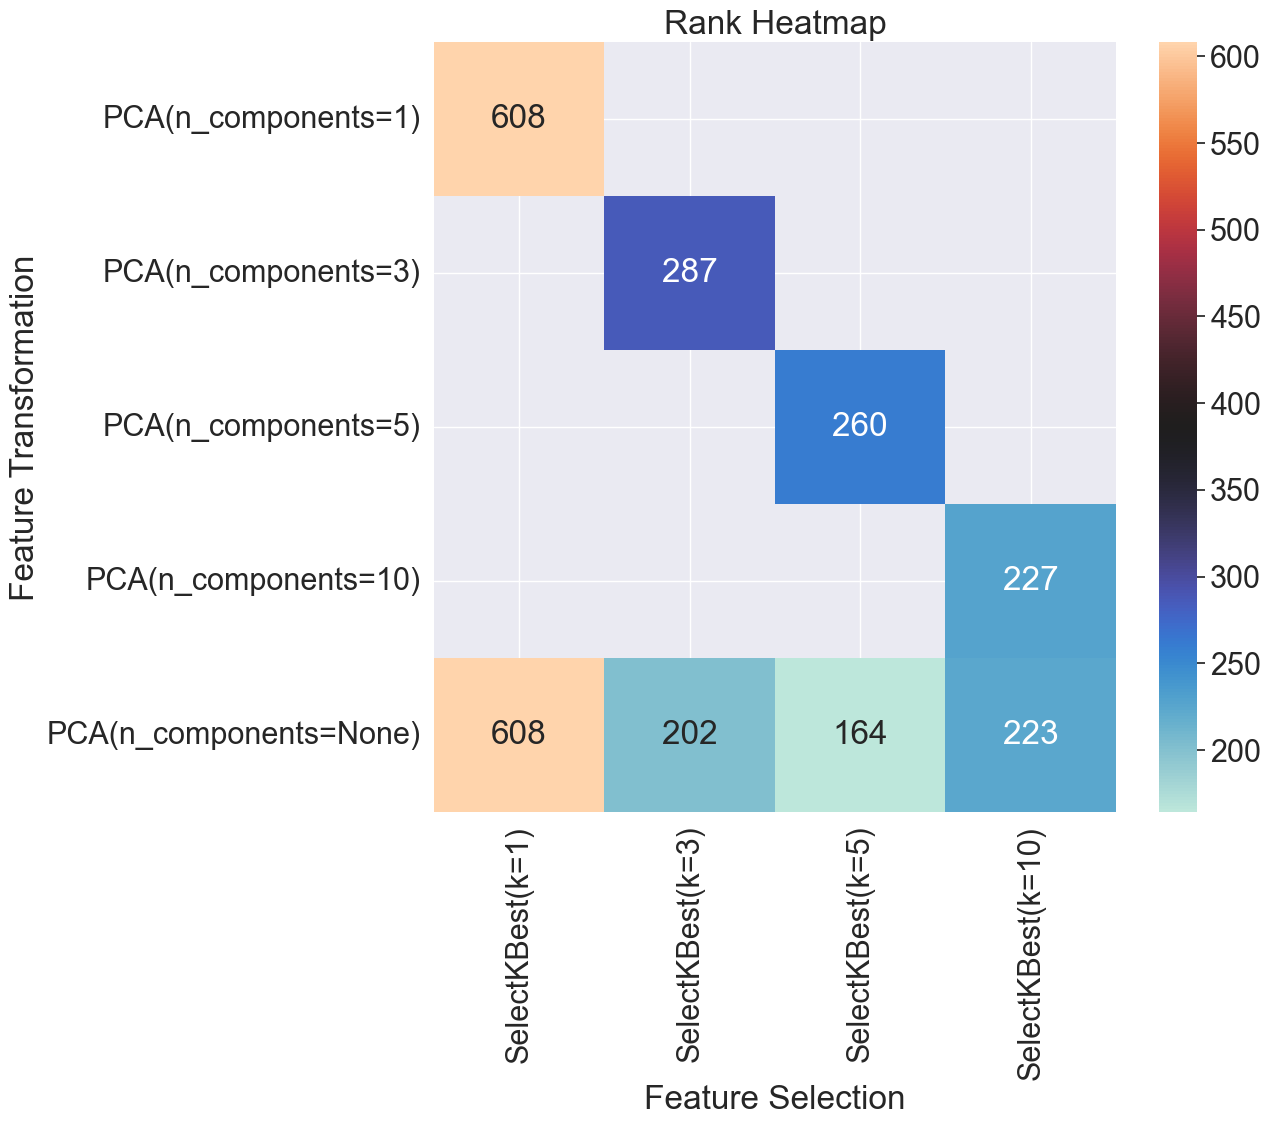

In [44]:
transform_select_exp_2 = transform_select.copy()
transform_select_exp_2 = transform_select_exp_2.loc[['PCA(n_components=1)', 'PCA(n_components=3)', 'PCA(n_components=5)', 'PCA(n_components=10)', 'PCA(n_components=None)']]
transform_select_exp_2 = transform_select_exp_2[['SelectKBest(k=1)', 'SelectKBest(k=3)', 'SelectKBest(k=5)', 'SelectKBest(k=10)']]
transform_select_exp_2.loc[['PCA(n_components=3)', 'PCA(n_components=5)', 'PCA(n_components=10)'], 'SelectKBest(k=1)'] = np.NaN
transform_select_exp_2.loc['PCA(n_components=10)', ['SelectKBest(k=3)', 'SelectKBest(k=5)']] = np.NaN
transform_select_exp_2.loc['PCA(n_components=5)', 'SelectKBest(k=3)'] = np.NaN

plt.figure(figsize=(11, 10))
sns.heatmap(transform_select_exp_2, cmap='icefire', annot=True, fmt='.0f')
plt.title('Rank Heatmap')
plt.xlabel('Feature Selection')
plt.ylabel('Feature Transformation')
plt.show()

Plot the average rank heatmap between Transformation and Selection steps but only the part required for Experiment 3.

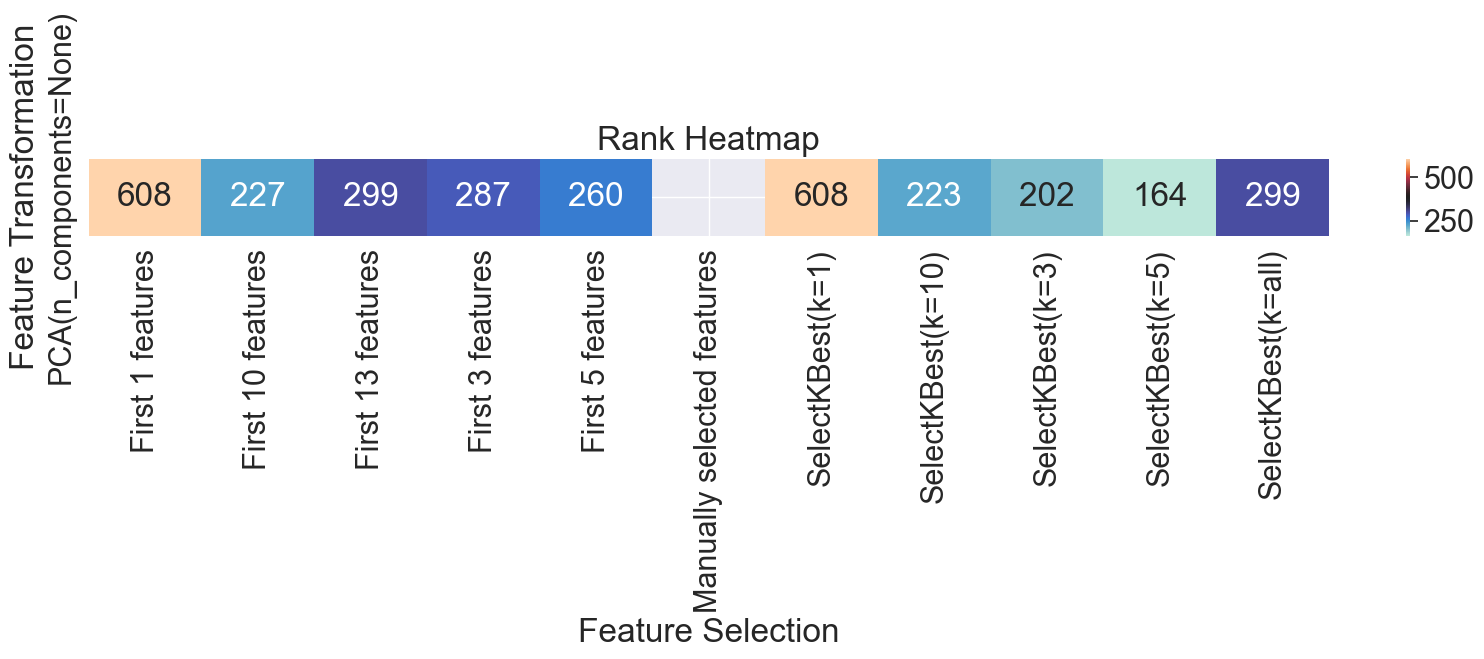

In [45]:
transform_select_exp_3 = transform_select.copy()
transform_select_exp_3 = transform_select_exp_3.loc[['PCA(n_components=None)']]

plt.figure(figsize=(20, 1))
sns.heatmap(transform_select_exp_3, cmap='icefire', annot=True, fmt='.0f')
plt.title('Rank Heatmap')
plt.xlabel('Feature Selection')
plt.ylabel('Feature Transformation')
plt.show()

Display the PCA components variance.

In [46]:
X_scaled = MinMaxScaler().fit_transform(X)

pca = PCA()
pca_features = pca.fit_transform(X_scaled)

pd.DataFrame(pca.explained_variance_ratio_)

0
0   0.407495
1   0.189704
2   0.085617
3   0.074267
4   0.055653
5   0.046588
6   0.036639
7   0.024088
8   0.022744
9   0.022510
10  0.013813
11  0.012732
12  0.008151

Show which PCA components are selected depending on k using SelectKBest.

In [47]:
selected_k_best_df = pd.DataFrame()
for k in [1, 3, 5, 10]: 
    select_k_best = SelectKBest(k = k)
    select_k_best.fit(pca_features, y)
    selected_k_best_df.loc['Selected PCA Features', k] = ', '.join([feature_name[1:] for feature_name in select_k_best.get_feature_names_out()])
selected_k_best_df

1        3               5   \
Selected PCA Features  0  0, 1, 5  0, 1, 4, 5, 12   

                                                   10  
Selected PCA Features  0, 1, 3, 4, 5, 6, 7, 8, 11, 12

Plot the average rank heatmap between Transformation and Classification steps.

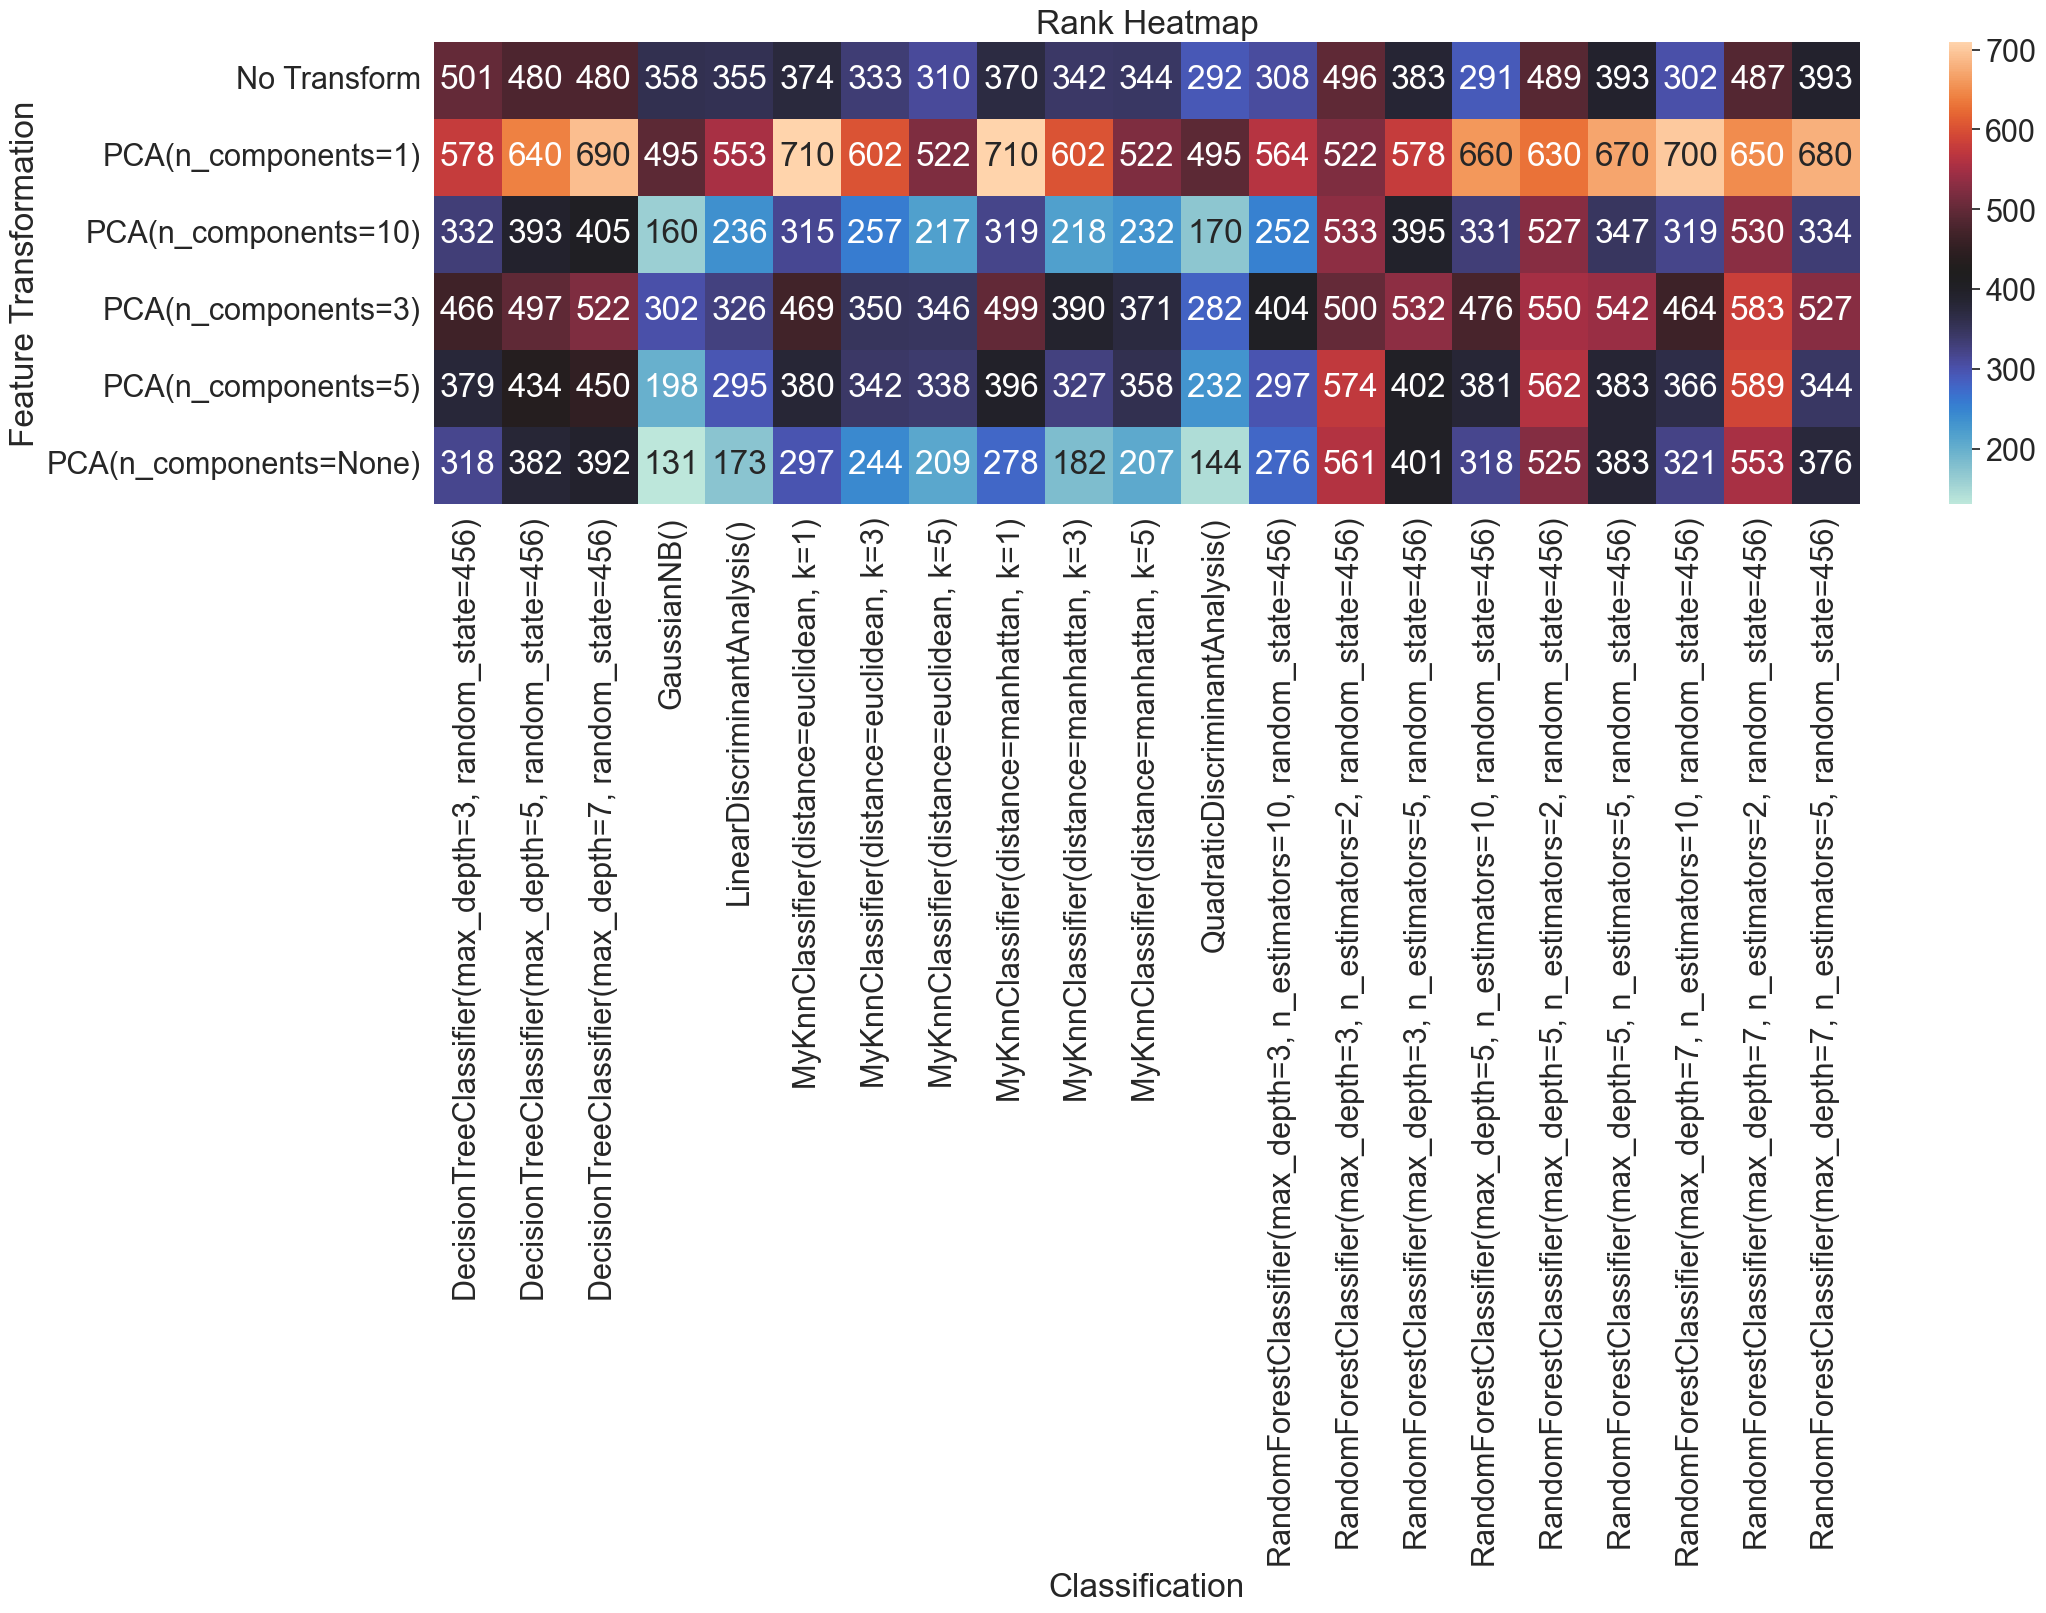

In [48]:
plt.figure(figsize=(23, 6))
sns.heatmap(transform_classify, cmap='icefire', annot=True, fmt='.0f')
plt.title('Rank Heatmap')
plt.xlabel('Classification')
plt.ylabel('Feature Transformation')
plt.show()

Plot the average rank heatmap between Selection and Classification steps.

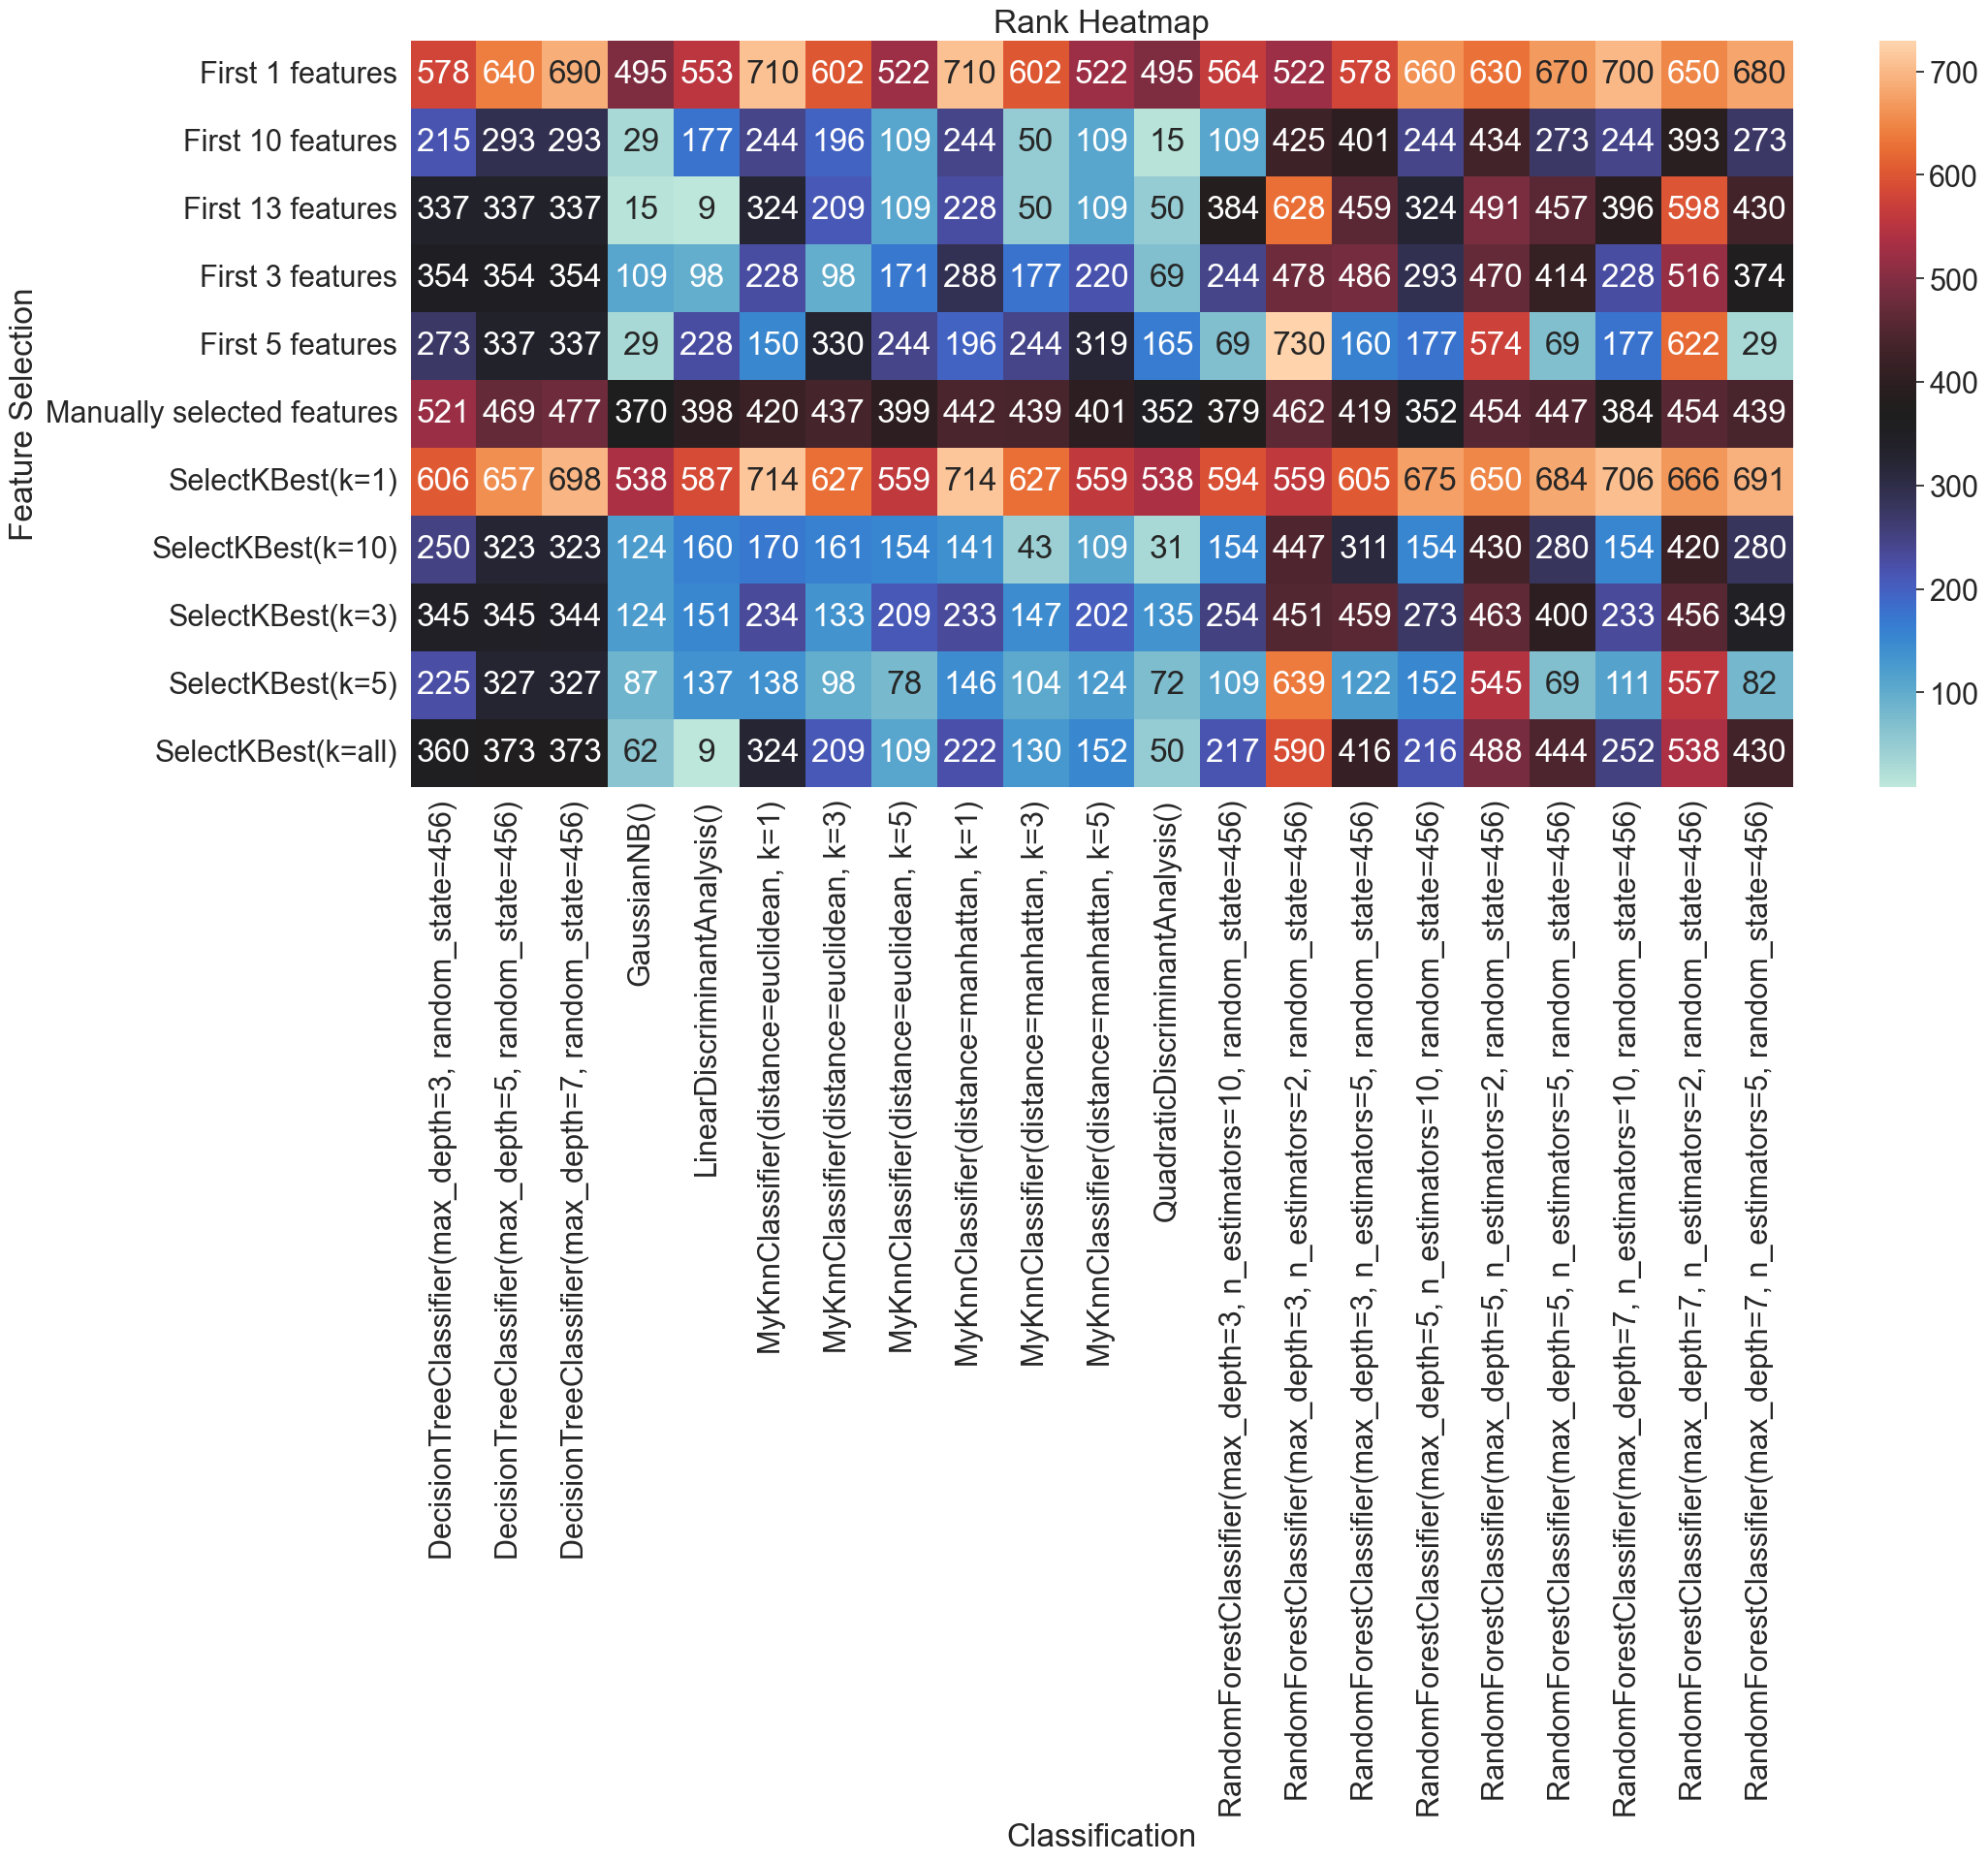

In [49]:
plt.figure(figsize=(23, 10))
sns.heatmap(select_classify, cmap='icefire', annot=True, fmt='.0f')
plt.title('Rank Heatmap')
plt.xlabel('Classification')
plt.ylabel('Feature Selection')
plt.show()

Preparing CV results for visualization with bar plots.

In [50]:
barplot_cv_results_df = cv_results_df.copy()
barplot_cv_results_df['pipeline'] = barplot_cv_results_df['param_transform'] + '\n' + barplot_cv_results_df['param_select'] + '\n' + barplot_cv_results_df['param_classify']
barplot_cv_results_df['mean_test_score'] = barplot_cv_results_df['mean_test_score'].astype(float)

Visualization of top best pipelines scores.

In [51]:
best_results_df = barplot_cv_results_df[barplot_cv_results_df['rank_test_score'] <= 2][['pipeline', 'mean_test_score']]
best_results_df

pipeline  \
217  PCA(n_components=None)
SelectKBest(k=5)
MyKnnClassifier(distance=euclidean, k=3)   
242           PCA(n_components=None)
SelectKBest(k=5)
QuadraticDiscriminantAnalysis()   
148    PCA(n_components=10)
SelectKBest(k=5)
MyKnnClassifier(distance=manhattan, k=5)   
144    PCA(n_components=10)
SelectKBest(k=5)
MyKnnClassifier(distance=manhattan, k=3)   
227  PCA(n_components=None)
SelectKBest(k=5)
MyKnnClassifier(distance=manhattan, k=1)   
237  PCA(n_components=None)
SelectKBest(k=5)
MyKnnClassifier(distance=manhattan, k=5)   
232  PCA(n_components=None)
SelectKBest(k=5)
MyKnnClassifier(distance=manhattan, k=3)   
82               PCA(n_components=5)
SelectKBest(k=3)
QuadraticDiscriminantAnalysis()   

     mean_test_score  
217          1.00000  
242          0.99435  
148          0.99435  
144          0.99435  
227          0.99435  
237          0.99435  
232          0.99435  
82           0.99435

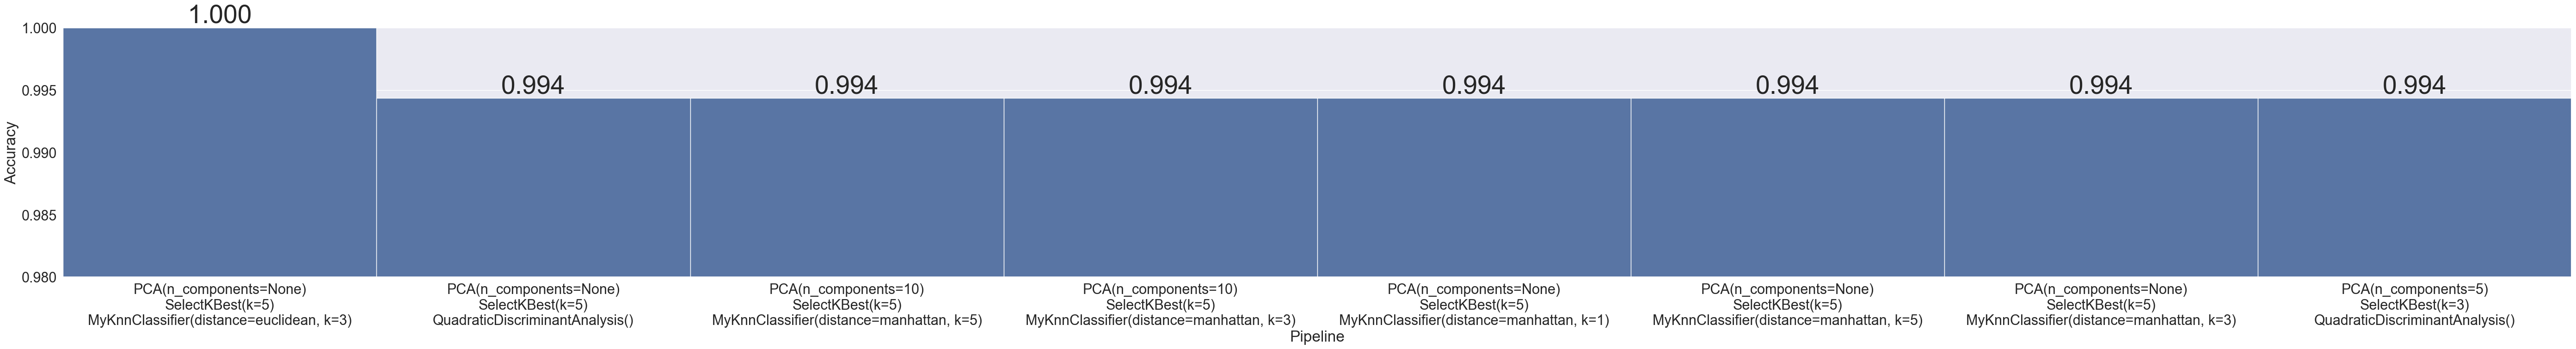

In [52]:
sns.set(rc={'figure.figsize':(70,7)})
sns.set(font_scale = 2)
ax = sns.barplot(data = best_results_df, x = 'pipeline', y = 'mean_test_score', width = 1)
ax.set(ylim=(0.98, 1))
ax.set_xlabel('Pipeline')
ax.set_ylabel('Accuracy')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', size = 40)

Visualization of top worst pipelines scores.

In [53]:
worst_results_df = barplot_cv_results_df[barplot_cv_results_df['rank_test_score'] >= 749][['pipeline', 'mean_test_score']]
worst_results_df

pipeline  \
400  No Transform
SelectKBest(k=1)
RandomForestClassifier(max_depth=5, n_estimators=10, random_state=456)   
335                                No Transform
SelectKBest(k=1)
MyKnnClassifier(distance=manhattan, k=3)   
320                                No Transform
SelectKBest(k=1)
MyKnnClassifier(distance=euclidean, k=3)   
390   No Transform
SelectKBest(k=1)
RandomForestClassifier(max_depth=5, n_estimators=2, random_state=456)   
355                                                            No Transform
SelectKBest(k=1)
GaussianNB()   
345                                         No Transform
SelectKBest(k=1)
QuadraticDiscriminantAnalysis()   
350                                            No Transform
SelectKBest(k=1)
LinearDiscriminantAnalysis()   
395   No Transform
SelectKBest(k=1)
RandomForestClassifier(max_depth=5, n_estimators=5, random_state=456)   

     mean_test_score  
400         0.646610  
335         0.640678  
320         0.640678  
390         0.640584  
355         0.635782  
345         0.635782  
350         0.635687  
395         0.629661

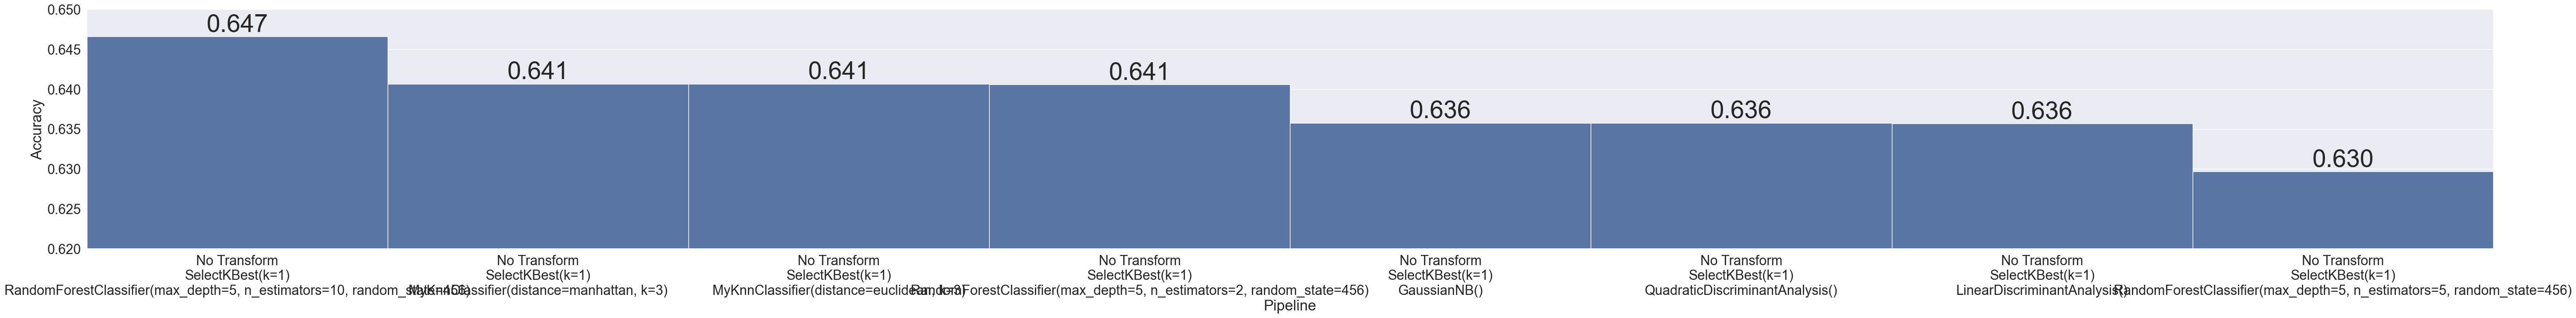

In [59]:
sns.set(rc={'figure.figsize':(70,7)})
sns.set(font_scale = 2)
ax = sns.barplot(data = worst_results_df, x = 'pipeline', y = 'mean_test_score', width = 1)
ax.set(ylim=(0.62, 0.65))
ax.set_xlabel('Pipeline')
ax.set_ylabel('Accuracy')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', size = 40)

Display pipelines without preprocessing features

In [64]:
cv_results_without_preprocessing_df = cv_results_df[
    (cv_results_df['param_transform'] == 'No Transform') & (cv_results_df['param_select'] == 'SelectKBest(k=all)')
].copy()
cv_results_without_preprocessing_df = cv_results_without_preprocessing_df[['param_classify', 'rank_test_score', 'mean_test_score']].drop_duplicates()
cv_results_without_preprocessing_df['mean_test_score'] = cv_results_without_preprocessing_df['mean_test_score'].astype(float)
cv_results_without_preprocessing_df

param_classify  \
354                                            LinearDiscriminantAnalysis()   
349                                         QuadraticDiscriminantAnalysis()   
389  RandomForestClassifier(max_depth=3, n_estimators=10, random_state=456)   
329                                MyKnnClassifier(distance=euclidean, k=5)   
359                                                            GaussianNB()   
404  RandomForestClassifier(max_depth=5, n_estimators=10, random_state=456)   
419  RandomForestClassifier(max_depth=7, n_estimators=10, random_state=456)   
344                                MyKnnClassifier(distance=manhattan, k=5)   
324                                MyKnnClassifier(distance=euclidean, k=3)   
339                                MyKnnClassifier(distance=manhattan, k=3)   
334                                MyKnnClassifier(distance=manhattan, k=1)   
319                                MyKnnClassifier(distance=euclidean, k=1)   
384   RandomForestClassifier(max_depth=3, n_estimators=5, random_state=456)   
364                   DecisionTreeClassifier(max_depth=3, random_state=456)   
374                   DecisionTreeClassifier(max_depth=7, random_state=456)   
369                   DecisionTreeClassifier(max_depth=5, random_state=456)   
414   RandomForestClassifier(max_depth=7, n_estimators=5, random_state=456)   
399   RandomForestClassifier(max_depth=5, n_estimators=5, random_state=456)   
409   RandomForestClassifier(max_depth=7, n_estimators=2, random_state=456)   
394   RandomForestClassifier(max_depth=5, n_estimators=2, random_state=456)   
379   RandomForestClassifier(max_depth=3, n_estimators=2, random_state=456)   

     rank_test_score  mean_test_score  
354                9         0.988795  
349               50         0.977589  
389               50         0.977589  
329              109         0.971940  
359              109         0.971940  
404              109         0.971940  
419              109         0.971940  
344              196         0.966290  
324              209         0.966290  
339              209         0.966290  
334              215         0.966196  
319              324         0.954991  
384              372         0.943691  
364              384         0.938136  
374              409         0.932486  
369              409         0.932486  
414              430         0.926836  
399              430         0.926836  
409              478         0.870998  
394              484         0.865348  
379              552         0.848117

Display pipelines for comparison with Reference 2.

In [72]:
cv_results_for_comparing_with_reference_2_df = cv_results_df[
    (cv_results_df['param_transform'] == 'No Transform') 
    & (cv_results_df['param_select'] == 'SelectKBest(k=all)')
    & ((cv_results_df['param_classify'] == 'QuadraticDiscriminantAnalysis()') | (cv_results_df['param_classify'] == 'LinearDiscriminantAnalysis()') | (cv_results_df['param_classify'] == 'MyKnnClassifier(distance=euclidean, k=1)'))
    ].copy()

cv_results_for_comparing_with_reference_2_df

param_transform        param_select  \
354    No Transform  SelectKBest(k=all)   
349    No Transform  SelectKBest(k=all)   
319    No Transform  SelectKBest(k=all)   

                               param_classify  rank_test_score  \
354              LinearDiscriminantAnalysis()                9   
349           QuadraticDiscriminantAnalysis()               50   
319  MyKnnClassifier(distance=euclidean, k=1)              324   

        mean_test_score  
354  0.9887947269303202  
349  0.9775894538606403  
319  0.9549905838041431